In [27]:
# 1D with central differencing scheme

import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# TODO: Add reference later
"""
A property φ is transported by means of convection and diffusion through
the one-dimensional domain; the boundary conditions are φ0 = 1 at x = 0 and 
φL = 0 at x = L. Using five equally spaced cells and the central differencing 
scheme for convection and diffusion, calculate the distribution of φ as a 
function of x for (i) Case 1: u = 0.1 m/s, (ii) Case 2: u = 2.5 m/s, 
and compare the results with the analytical solution (iii) Case 3: recalculate 
the solution for u = 2.5 m/s with 20 grid nodes and compare the results with 
the analytical solution. The following data apply: length L = 1.0 m, ρ = 1.0 kg/m3
, Γ = 0.1 kg/m.s.
"""

import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
L = 1.0              # Length in m
rho = 1.0            # Density in kg/m3
k = 0.1              # Diffusivity in kg/m.s
u = 0.1              # Velocity in m/s
n_nodes = 5
dx = L / n_nodes

# Boundary conditions
phi_x0 = 1
phi_xL = 0

# Calculate diffusion and mass flux terms
D = k / dx            # Diffusion conductance
F = u * rho           # Mass flux per unit area

# Calculate control volume nodes
x_grid = np.linspace(0, L - dx, n_nodes) + dx / 2

# Initialise the right-hand side vector
b = np.zeros(n_nodes)

# Initialise the diagonals of the matrix
a_W = D + 0.5 * F
a_E = D - 0.5 * F
a_P = a_W + a_E 

# Set up the main diagonal, super-diagonal, and sub-diagonal
main_diag = np.full(n_nodes, a_P)
sup_diag = np.full(n_nodes - 1, -a_E)
sub_diag = np.full(n_nodes - 1, -a_W)

# Modify the first and last nodes for boundary conditions
main_diag[0] = a_E + (2 * D + F)
b[0] = (2 * D + F) * phi_x0
main_diag[-1] = a_W + (2 * D - F)
b[-1] = (2 * D - F) * phi_xL

# Create a sparse tridiagonal matrix
diagonals = [main_diag, sup_diag, sub_diag]
A = diags(diagonals, [0, 1, -1], format='csr')

# Solve the linear system
phi_dist_num = spsolve(A, b)


In [26]:
def analytical_sol(x):
    return (phi_xL - phi_x0) * (np.exp(rho*u*x/k) - 1)/(np.exp(rho*u*L/k) - 1) + phi_x0

phi_dist_act = analytical_sol(x_grid)

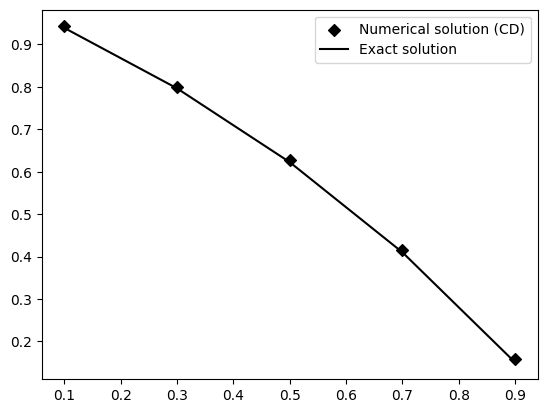

In [37]:
import matplotlib.pyplot as plt

plt.scatter(x_grid, phi_dist_num, marker='D', color='k')
plt.plot(x_grid, phi_dist_act, color='k')
plt.legend(['Numerical solution (CD)', 'Exact solution'])
plt.show()